# SCC.413 Applied Data Mining
# Week 18
# Authorship attribution (with single Tweets)

## Contents
* [Introduction](#intro)
* [Preamble](#preamble)
* [Document object and processors](#doc)
* [Dataset](#data)
* [Pipeline](#pipeline)
* [Error analysis](#error)
* [Exercise (not assessed)](#ex)

<a id="intro"></a>
## Introduction

In previous labs you have classified collections of Tweets (for a single user) as one document/instance in the classifier. Here, we instead treat individual tweets as documents, and attempt to classify these. We use authorship attribution as the task here, i.e. predicting the user who produced the Tweet.

<a id="preamble"></a>
## Preamble
Below are imports and helper functions from previous labs.

In [1]:
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

A couple of methods for showing classifier results (from 1st classification lab):

In [2]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

<a id="doc"></a>
## Document object and processors

Functions for processing text, and producing a Document class.

In [3]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.ht_fql = Counter()
        self.num_tokens = 0
        self.text = ""
        
    def extract_features_from_text(self, text):
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        self.text += text
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

A transformer to convert `Document` to extract features via a callable method:

In [4]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [5]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_ht_fql(document):
    return document.ht_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

<a id="data"></a>
## Dataset

Import Tweets as single Document, with metadata of user included. You could utilise other metadata to predict party of user (or age/gender from celebs data) of a single Tweet.

In [6]:
def import_tweets_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            tweets = data.pop('tweets')
            metadata = data
        print("Processing " + metadata['screen_name'])
        for tweet in tweets:
            doc = Document(meta=metadata)
            doc.extract_features_from_text(tweet['text'])
            yield doc

In [7]:
corpus = []
corpus.extend(import_tweets_json("mps-json-10"))

Processing @Anna_Soubry
Processing @tom_watson
Processing @BorisJohnson
Processing @theresa_may
Processing @jeremycorbyn
Processing @Jeremy_Hunt
Processing @CarolineLucas
Processing @YvetteCooperMP
Processing @JoJohnsonUK
Processing @ChukaUmunna


In [8]:
y = [d.meta['screen_name'] for d in corpus]
X = corpus

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

13828 3458
13828 3458


<a id="pipeline"></a>
## Pipeline

Here is a sample pipeline to be used with gridsearch, with a feature union of hashtags, words or function words, and some text stats. Using either a naive bayes or logisitic regression classifier.

In [10]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('hts', Pipeline([
                ('processor', DocumentProcessor(process_method = get_ht_fql)),
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', None), # to be set by grid search.
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [50, 100, 150, 500],
    'clf': [MultinomialNB(), LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')],
}

In [11]:
search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('hts',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=<function get_ht_fql at 0x7f5fdf936f28>)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.floa...
                                                    solver='

In [12]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_selector__k,param_union__word__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,1.291093,0.081232,0.319057,0.002290,"MultinomialNB(alpha=1.0, class_prior=None, fit...",50,<function get_fws_fql at 0x7f5fdf936c80>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.256688,0.280550,...,0.010970,16,0.241112,0.265840,0.270416,0.274718,0.254584,0.261334,0.012136,16
1,0.366772,0.041641,0.098582,0.011465,"MultinomialNB(alpha=1.0, class_prior=None, fit...",50,<function get_tokens_fql at 0x7f5fdf936ea0>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.407086,0.426970,...,0.008447,9,0.404495,0.420730,0.413971,0.398149,0.411089,0.409687,0.007776,9
2,1.466797,0.187438,0.380290,0.060966,"MultinomialNB(alpha=1.0, class_prior=None, fit...",100,<function get_fws_fql at 0x7f5fdf936c80>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.313449,0.317787,...,0.006272,15,0.300117,0.315153,0.319383,0.323174,0.307851,0.313136,0.008262,14
3,0.333714,0.043274,0.089740,0.002376,"MultinomialNB(alpha=1.0, class_prior=None, fit...",100,<function get_tokens_fql at 0x7f5fdf936ea0>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.452278,0.481923,...,0.010226,6,0.454106,0.480833,0.466731,0.459610,0.462514,0.464759,0.009025,6
4,1.341710,0.087309,0.346002,0.034706,"MultinomialNB(alpha=1.0, class_prior=None, fit...",150,<function get_fws_fql at 0x7f5fdf936c80>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.331887,0.334056,...,0.003740,13,0.322143,0.332155,0.335578,0.338366,0.324834,0.330615,0.006201,13
5,0.396300,0.043397,0.115529,0.027118,"MultinomialNB(alpha=1.0, class_prior=None, fit...",150,<function get_tokens_fql at 0x7f5fdf936ea0>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.476500,0.514100,...,0.012507,5,0.479779,0.516557,0.491869,0.488239,0.493069,0.493902,0.012244,5
6,1.540181,0.187964,0.393140,0.079505,"MultinomialNB(alpha=1.0, class_prior=None, fit...",500,<function get_fws_fql at 0x7f5fdf936c80>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.372740,0.384309,...,0.008368,11,0.373577,0.384364,0.375131,0.396819,0.380445,0.382067,0.008315,11
7,0.342080,0.014703,0.095737,0.005786,"MultinomialNB(alpha=1.0, class_prior=None, fit...",500,<function get_tokens_fql at 0x7f5fdf936ea0>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.569053,0.581345,...,0.004996,2,0.571538,0.584205,0.574159,0.583303,0.583747,0.579391,0.005413,2
8,1.625800,0.018836,0.334494,0.011422,"LogisticRegression(C=1.0, class_weight=None, d...",50,<function get_fws_fql at 0x7f5fdf936c80>,"{'clf': LogisticRegression(C=1.0, class_weight...",0.324657,0.332610,...,0.010303,14,0.299897,0.310393,0.303391,0.334732,0.307482,0.311179,0.012304,15
9,0.859068,0.093551,0.145029,0.027249,"LogisticRegression(C=1.0, class_weight=None, d...",50,<function get_tokens_fql at 0x7f5fdf936ea0>,"{'clf': LogisticRegression(C=1.0, class_weight...",0.450832,0.468185,...,0.006394,7,0.440331,0.458526,0.451849,0.449539,0.442810,0.448611,0.006510,7


In [13]:
search.best_params_

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                    solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'selector__k': 500,
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

Accuracy:  0.6477732793522267
                 precision    recall  f1-score   support

   @Anna_Soubry       0.69      0.67      0.68       331
  @BorisJohnson       0.67      0.56      0.61       286
 @CarolineLucas       0.71      0.66      0.69       456
   @ChukaUmunna       0.61      0.58      0.60       279
   @Jeremy_Hunt       0.66      0.70      0.68       516
   @JoJohnsonUK       0.75      0.65      0.69       156
@YvetteCooperMP       0.67      0.58      0.62       322
  @jeremycorbyn       0.65      0.69      0.67       442
   @theresa_may       0.56      0.44      0.49       170
    @tom_watson       0.56      0.73      0.64       500

       accuracy                           0.65      3458
      macro avg       0.65      0.63      0.64      3458
   weighted avg       0.65      0.65      0.65      3458

[[223   1  10  13   8   2  15   6   2  51]
 [  8 159   8   8  46   5   9  12  11  20]
 [  9   6 303  30  26   6  17  28   7  24]
 [  7   3  30 162  14   1  14  16   6  2

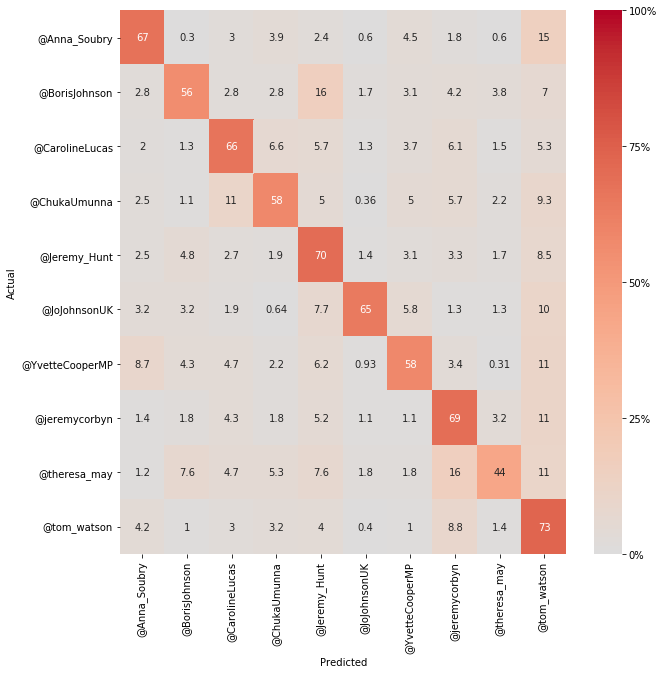

In [14]:
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)

Once evaluated, we can see that we can predict the author of a Tweet quite accurately, with some users easier to predict than others. Why might this be?

notes:

<a id="error"></a>
## Error analysis

We can perform some error analysis by looking at the text alongside the predictions:

In [15]:
X_test_texts = [x.text for x in X_test]

In [16]:
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])

In [17]:
pd.options.display.max_colwidth = 300
df.head(10)

,Tweet,Actual,Predicted
0,She was even better after it - #dontmesswithSuRie #eurovision https://t.co/ROQnDECQEl,@YvetteCooperMP,@YvetteCooperMP
1,The OBR makes clear that the Tory corporation tax cuts will cost the Treasury billions. \n\nOur public services desperately need that money. #SpringStatement https://t.co/XOcZUCWv1v,@CarolineLucas,@jeremycorbyn
2,@philipjcowley Says a future VC 😉,@tom_watson,@tom_watson
3,"Delighted to be an @theRCN Nursing Champion for #Brighton Pavilion. Today’s @CommonsHealth report shows we have a lot to do to make our current &amp; future nursing staff feel valued, supported &amp; motivated in a health care system that celebrates their contribution to patient care.",@CarolineLucas,@CarolineLucas
4,"In Thurrock, I met first time voters who voted Labour. I'm proud that our vision of hope inspired so many to vote for the very first time. https://t.co/nQp7Hfj5fa",@jeremycorbyn,@jeremycorbyn
5,"@piersmorgan Too right. Just enjoy the moment and remember no one can go back in time to change what has happened, so work on your present to make yourself a wonderful future. Happy New Year in advance.",@tom_watson,@Jeremy_Hunt
6,"Hang on. Police officers were cut by 2,715 in 12 months from Sept 2015 - Sept 2016 #canttrustawordshesays https://t.co/UYBNMwaSf2",@YvetteCooperMP,@YvetteCooperMP
7,@joerayment91 @GloriaDePiero @TracyBrabin https://t.co/vz0tkGxmNc,@tom_watson,@tom_watson
8,@tobyh45 @mccanntb @LBC Ring in Toby.,@tom_watson,@tom_watson
9,Brexiteers promised a ban on live animal exports. \n\nNow @MichaelGove says it won't happen. \n\nThis Tory Brexit is built on lies. \n\nWe urgently need a #PeoplesVote https://t.co/P5bV2E59hR,@CarolineLucas,@CarolineLucas


For example, we can see when Theresa May's tweets are predicted incorrectly: 

In [18]:
df[df['Actual'].str.match("@theresa_may") & ~df['Predicted'].str.match("@theresa_may")]

,Tweet,Actual,Predicted
31,"Labour’s policies would be devastating to businesses and working families across our country.\n \nBy contrast, under this Government wages are growing, unemployment is falling and we are delivering a Brexit deal that is good for our economy.\n\n#PMQs https://t.co/YkvbGgHC6B",@theresa_may,@jeremycorbyn
39,"Labour has turned its back on investment, growth, jobs. A Labour Party that will always put politics before people. https://t.co/Hnua5uIAo5",@theresa_may,@tom_watson
76,"Glad the @RedDevilsOnline were able to help, @Schofe. Happy birthday @ThisMorning! #ThisMorning30 https://t.co/sb7keZwEsX",@theresa_may,@tom_watson
107,UK is offering help to those hit by the devastating Hurricane Irma https://t.co/wVbTOei3x0,@theresa_may,@BorisJohnson
120,Delighted to see some of Britain's unsung heroes honoured at tonight's @PrideOfBritain awards. https://t.co/2Yq022fkeP,@theresa_may,@tom_watson
...,...,...,...
3316,My Government is developing proposals to crack down on puppies being reared in unhealthy circumstances by unscrupulous breeders who have a total disregard for their welfare. It’s absolutely right we do everything we can to eradicate animal cruelty from our society. https://t.co/jXe4FiyNdw,@theresa_may,@jeremycorbyn
3364,"Please do follow and support @Equinepuk - a Leeds based equine therapy organisation championed by @andreajenkyns. It offers free sessions to children struggling with bullying, autism and learning difficulties; and adults battling depression and overcoming other illnesses. https://t.co/ZkB9pDBWI7",@theresa_may,@tom_watson
3416,Vote for better local services and lower council tax. Vote @Conservatives today. https://t.co/S5HAXIx4Ut,@theresa_may,@tom_watson
3440,Thank you @Malala. International experts agree that young people need 12 years of quality education if they’re to fulfil their potential. I want #CHOGM18 to be the summit where the Commonwealth agrees to make that the goal for all our members. https://t.co/TBNfU9GEJk,@theresa_may,@BorisJohnson


Or when predicted as a specific other person:

In [19]:
df[df['Actual'].str.match("@theresa_may") & df['Predicted'].str.match("@jeremycorbyn")]

,Tweet,Actual,Predicted
31,"Labour’s policies would be devastating to businesses and working families across our country.\n \nBy contrast, under this Government wages are growing, unemployment is falling and we are delivering a Brexit deal that is good for our economy.\n\n#PMQs https://t.co/YkvbGgHC6B",@theresa_may,@jeremycorbyn
453,"In my speech tomorrow, I will show how and why my Government must fulfil our duty to Britain https://t.co/vOp8HRgoag",@theresa_may,@jeremycorbyn
472,Congratulations to @PaulDaviesPembs who has today been elected Leader of @WelshConserv in the Welsh Assembly. There has never been a more vital time for us to hold the failing Labour-run Welsh Government to account. I know he’ll do a fantastic job speaking up for the Welsh people,@theresa_may,@jeremycorbyn
477,I would like to thank everyone working in our emergency services on #999DayUK. They go above and beyond every day to help save lives and keep us safe.,@theresa_may,@jeremycorbyn
584,"It was great to meet so many inspirational people last night @10DowningStreet, supporting the government’s important partnership with #SoccerAid for @Unicef. Together we’re helping children in danger around the world. https://t.co/L1ngbdM07R",@theresa_may,@jeremycorbyn
754,"On the 350th anniversary of Guru Gobind Singh's birth, I'd like to wish all Sikhs celebrating a very blessed and happy Gurpurab.",@theresa_may,@jeremycorbyn
790,"We will create jobs, fund public services &amp; build a country that works for everyone. Labour will borrow £500 billion, hurting working people https://t.co/DqD4zzt0IT",@theresa_may,@jeremycorbyn
1020,I am deeply saddened by the tragic loss of life at Grenfell Tower. My thoughts are with all those affected and the emergency services.,@theresa_may,@jeremycorbyn
1159,"I had a wonderful time spending today with military personnel, veterans, and their families at Armed Forces Day celebrations in Llandudno. #ArmedForcesDay2018 https://t.co/9p8if8KwLh",@theresa_may,@jeremycorbyn
1388,I was delighted to host an Eid reception at @10DowningStreet to celebrate the inspiring contribution made by British Muslims in this country #EidMubarak https://t.co/EktPQE5W40,@theresa_may,@jeremycorbyn


<a id="ex"></a>
## Exercise (not assessed)

The classifier above works quite well, but is using hashtags and words, which are going to be topic/time related. Would the same features work for tweets months or years apart? Try to develop a new feature set that is restricted to style features only, and evaluate on this. You could also use the celebs data, or use a larger set of authors, to test your new model.